# Принятие решений в интернет-магазине по результатам A/B теста

## Основные положения

### Описание проекта

На начало выполнения проекта имеется список из 9 гипотез по увеличению выручки интернет-магазина. Для приоритизации гипотез необходмо применить фреймворки ICE и RICE. Далее необходимо проанализировать данные проведенного A/B теста, которые представлены в виде двух csv файлов. 

### Цель работы

Цель работы - приоритизировать гипотезы и проанализировать результат A/B-теста. 

### План выполнения работ

Последовательность выполнения работ:
- анализ кумулятивного изменения выручки, среднего чека и количества заказов на посетителя;
- определение аномальных данных;
- расчет статистической значимости различий анализируемых параметров по "сырым" данным;
- расчет статистической значимости различий анализируемых параметров по "очищенным" данным;
- принять решение по результатам теста;
- описать выводы.

## Выполнение работы

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats

### Часть 1. Приоритизация гипотез.

#### Подготовка данных

In [2]:
h_data = pd.read_csv('/datasets/hypothesis.csv')
display(h_data.info())
HTML(h_data.to_html())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Типы данных корректные. Названия колонок преобразуем в строчные.

In [3]:
print(h_data.columns)
h_data.columns = h_data.columns.str.lower()
print(h_data.columns)

Index(['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Efforts'], dtype='object')
Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')


#### Приоритизация по ICE

Расчет приоритетов по фреймфорку ICE производится по формуле:
$ICE\ SCORE = \frac{Impact * Confidence}{Efforts}$.

Добавим новый столбец с соответствующим приоритетом.

In [4]:
h_data['ice'] = h_data['impact'] * h_data['confidence'] / h_data['efforts']
HTML(h_data.sort_values(by='ice', ascending = False).round({'ice':3}).to_html())

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000


Наибольший приоритет по фреймворку ICE получила гипотеза "Запустить акцию, дающую скидку на товар в день рождения".

#### Приоритизация по RICE

Расчет приоритетов по фреймфорку RICE производится по формуле:
$RICE\ SCORE = \frac{Reach * Impact * Confidence}{Efforts} = Reach * ICE\ SCORE$

То есть, фактически, мы добавляем учет охвата к предыдущему приоритету.
Добавим новый столбец с соответствующим приоритетом.

In [5]:
h_data['rice'] = h_data['reach'] * h_data['ice']
HTML(h_data.sort_values(by='rice', ascending = False).round({'ice':3, 'rice':3}).to_html())

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000,3.0


Наибольший приоритет по фреймворку RICE получила гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

#### Изменение приоритизации при смене фреймворка

В целом, состав ТОП5 приоритетов не изменился. Но значительно изменился их порядок ранжирования. Это произошло потому, что в случае RICE мы дополнительно учли охват воздействия гипотез. 

### Часть 2. Анализ A/B-теста

Получаем и проверяем данные результатов теста

#### Проверка данных по заказам

In [6]:
orders = pd.read_csv('/datasets/orders.csv')
display(orders.info())
orders

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


Делаем названия колонок более удобными для работы, изменяем тип данных колонки с датами.

In [7]:
orders = orders.rename(columns = {'transactionId':'transaction_id', 'visitorId':'visitor_id'})
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [8]:
orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


Проверяем состав данных.

In [9]:
print('Полных дубликатов: {0}, \n "N/A":\n{1},\n\nуникальных значений: \n{2}\n Мин. выручка: {3}, макс. выручка: {4:_}'
      .format(
        orders.duplicated().sum(),
        orders.isna().sum(),
        orders.nunique(),
        orders['revenue'].min(),  
        orders['revenue'].max()
      )
)

Полных дубликатов: 0, 
 "N/A":
transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64,

уникальных значений: 
transaction_id    1197
visitor_id        1031
date                31
revenue            713
group                2
dtype: int64
 Мин. выручка: 50, макс. выручка: 1_294_500


In [10]:
print('Минимальная дата: {0:%Y-%m-%d}, максимальная дата: {1:%Y-%m-%d}'
      .format(orders['date'].min(), orders['date'].max()) )
print(orders['group'].value_counts())

Минимальная дата: 2019-08-01, максимальная дата: 2019-08-31
B    640
A    557
Name: group, dtype: int64


Проверяем пользователей, которые могли попасть в обе группы.
    Берем список заказов пользователей группы B, и оставляем в нем только записи тех пользователей, которые есть в группе A, затем оставляем только колонку ID пользователей и оставляем только уникальные. 

In [11]:
dupl_vis_id = orders.query('group == "B"')[orders.query('group == "B"')['visitor_id']\
                                       .isin(orders.query('group == "A"')['visitor_id'])]\
                                        ['visitor_id'].unique()
print('Количество одинаковых пользователей в обоих группах:', len(dupl_vis_id))

Количество одинаковых пользователей в обоих группах: 58


Удаляем записи с пользователями, попавшими в обе группы и проверяем наличие повторяющихся пользователей.

In [12]:
orders = orders.loc[~orders['visitor_id'].isin(dupl_vis_id)]
#orders2.query('group == "B"')['visitor_id'].isin(orders2.query('group == "A"')['visitor_id']).sum()

dupl_vis_id = orders.query('group == "B"')[orders.query('group == "B"')['visitor_id']\
                                       .isin(orders.query('group == "A"')['visitor_id'])]\
                                        ['visitor_id'].unique()
print('Количество одинаковых пользователей в обоих группах:', len(dupl_vis_id))

Количество одинаковых пользователей в обоих группах: 0


#### Проверка данных по посетителям

In [13]:
visitors = pd.read_csv('/datasets/visitors.csv')
display(visitors.info())
visitors

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


Изменяем тип данных колонки с датами.

In [14]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Проверяем состав данных.

In [15]:
print('Полных дубликатов: {0}, \n "N/A":\n{1},\n\nуникальных значений: \n{2}\n Мин. выручка: {3}, макс. выручка: {4:_}'
      .format(
        visitors.duplicated().sum(),
        visitors.isna().sum(),
        visitors.nunique(),
        visitors['visitors'].min(),  
        visitors['visitors'].max()
      )
)

Полных дубликатов: 0, 
 "N/A":
date        0
group       0
visitors    0
dtype: int64,

уникальных значений: 
date        31
group        2
visitors    58
dtype: int64
 Мин. выручка: 361, макс. выручка: 770


In [16]:
print('Минимальная дата: {0:%Y-%m-%d}, максимальная дата: {1:%Y-%m-%d}'
      .format(visitors['date'].min(), visitors['date'].max()) )
print(visitors['group'].value_counts())

Минимальная дата: 2019-08-01, максимальная дата: 2019-08-31
A    31
B    31
Name: group, dtype: int64


#### Задача 1. График кумулятивной выручки.

Формируем кумулятивные данные по дням по заказам.

In [17]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

#агрегируем по заказам
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date' : 'max',
          'group' : 'max',
          'transaction_id' : 'nunique',
          'visitor_id' : 'nunique',
          'revenue' : 'sum'}),
    axis=1).sort_values(by=['date','group'])

#агрегированные кумулятивные по дням данные о посетителях
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}),
    axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам новые названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


Строим график кумулятивной выручки по датам по группам.

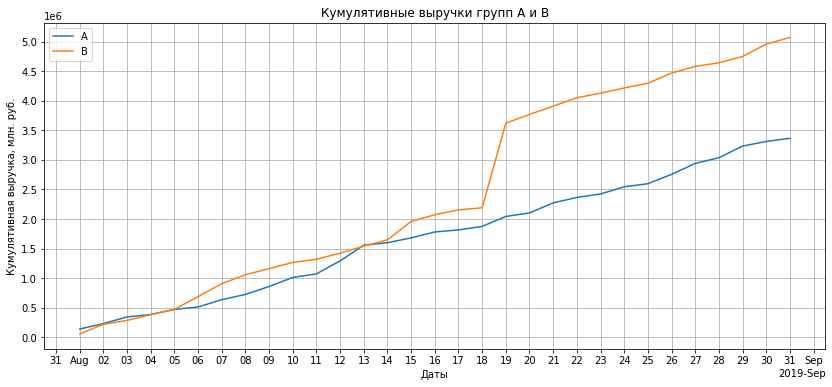

In [18]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

fig = plt.figure(figsize = (14,6))

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Кумулятивные выручки групп A и B')
ax.set_ylabel('Кумулятивная выручка, млн. руб.')
ax.set_xlabel('Даты')
ax.grid(True)
locator = mdates.DayLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
yticks = np.arange(0, 6500000, 500000)
ax.set_yticks(yticks)

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend();

<b>Вывод:</b>

Кумулятивная выручка постоянно растет по обеим группам. В целом, рост происходит схожими темпами, однако у группы B заметен сильный всплеск выучки 19.08.19. Это могло произойти либо изза необычного большого количества заказов в этот день, либо изза заказа с высоким чеком.

#### Задача 2. График кумулятивного среднего чека.

Размер среднего чека на дату считаем, как отношение кумулятивной выручки к кумулятивному числу заказов на эту дату. 

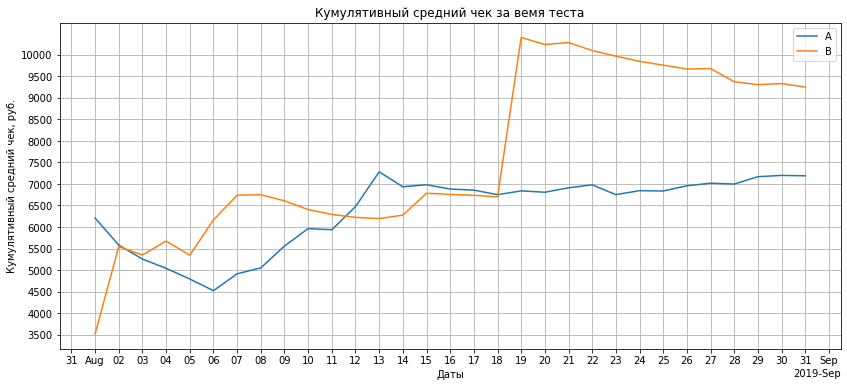

In [19]:

fig = plt.figure(figsize = (14,6))

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Кумулятивный средний чек за вемя теста')
ax.set_ylabel('Кумулятивный средний чек, руб.')
ax.set_xlabel('Даты')
ax.grid(True)

locator = mdates.DayLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
yticks = np.arange(3500, 10500, 500)
ax.set_yticks(yticks)

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.show();

Видно, что в группе B  значительно увеличился средний чек 19 августа. И это была не типичная ситуация, так как далее кумулятивные данные начали снижаться за счет более низкиз средних чеков в последующие дни.

Кроме того, в той же группе B  и до этого случались увеличения чека 2 августа, а также с 6 по 8, 15 августа.

В группе A средний чек сначала снижался (причем значительно, поскольку мы из предыдущего графика знаем, что общая выручка росла). Но с 7 августа размер чека постоянно рос до 13 августа. Далее размер среднего чека постепенно стабилизировался.

#### Задача 3. График относительного между группами изменения кумулятивного среднего чека.

Размер среднего чека на дату считаем, как отношение кумулятивной выручки к кумулятивному числу заказов на эту дату. 

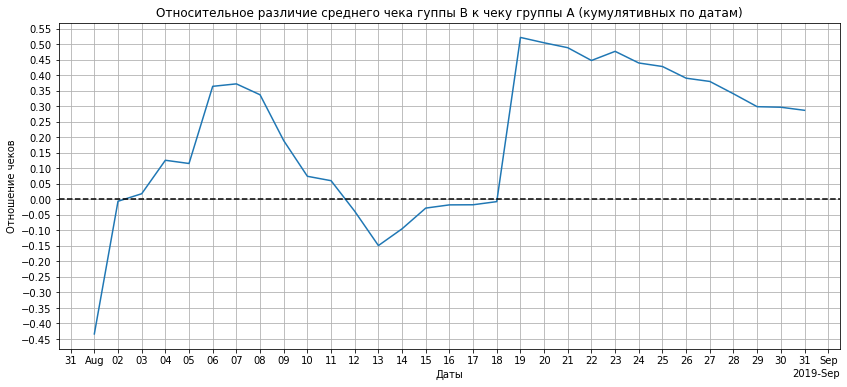

In [20]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB,
                                                   left_on='date', right_on='date',
                                                   how='left', suffixes=['A', 'B'])
fig = plt.figure(figsize = (14,6)) 

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Относительное различие среднего чека гуппы B к чеку группы A (кумулятивных по датам)')
ax.set_ylabel('Отношение чеков')
ax.set_xlabel('Даты')
ax.grid(True)

locator = mdates.DayLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
yticks = np.arange(-0.5, 0.6, 0.05)
ax.set_yticks(yticks)


# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'],
         (mergedCumulativeRevenue['revenueB']/
          mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/
          mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

Изначально средний чек у группы A был выше.Затем большую часть времени кумулятивный средний чек группы B был выше, чем у группы A. 

Исключение составляет период с 12 по 15 августа.

Последние 3 дня соотношение было приблизительно постоянным.

Первый пик обусловлен тем, что еще не были накоплены суммарные данные и любые значения, отличные от предыдущих, имели более сильное влияние на форму графика (кумулятивное значение), к тому же, у группы B в это время постепенно увеличивался средний чек, а у группы A уменьшался, что еще больше усилило наклон графика относительного различия.

#### Задача 4. График кумулятивного среднего количества заказов на посетителя.

Размер среднего чека на дату считаем, как отношение кумулятивной выручки к кумулятивному числу заказов на эту дату. 

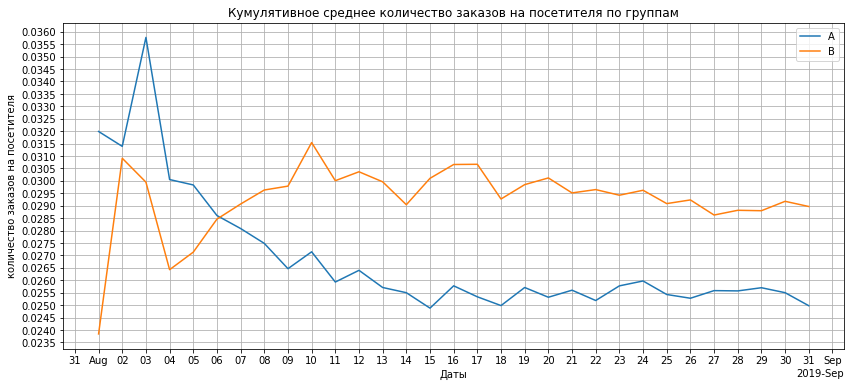

In [21]:
# считаем среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

fig = plt.figure(figsize = (14,6)) 

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Кумулятивное среднее количество заказов на посетителя по группам')
ax.set_ylabel('количество заказов на посетителя')
ax.set_xlabel('Даты')
ax.grid(True)

locator = mdates.DayLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
yticks = np.arange(0.02, 0.038, 0.0005)
ax.set_yticks(yticks)



# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend();



Видим вначале значительные колебания конверсии, что говорит о том, что периоды одинаковой конверсии не постоянны, а уровень конверсии постоянно меняется, однако со временем при кумулятивном рассмотрении эти неравномерности сглаживаются.

Соответственно, постепенно становится хорошо заметно установление у групп A и B стабильно разных значений конверсии. 

#### Задача 5. График относительного изменения кумулятивного среднего количества заказов на посетителя

Расчитываем и строим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

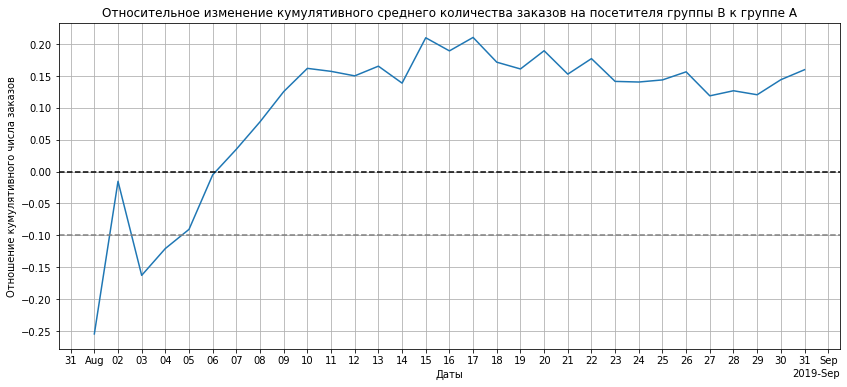

In [22]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']],
    left_on='date', right_on='date',
    how='left', suffixes=['A', 'B'])

fig = plt.figure(figsize = (14,6)) 

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
ax.set_ylabel('Отношение кумулятивного числа заказов')
ax.set_xlabel('Даты')
ax.grid(True)

locator = mdates.DayLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
yticks = np.arange(-0.3, 0.25, 0.05)
ax.set_yticks(yticks)



plt.plot(mergedCumulativeConversions['date'],
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--');

Видно, что начиная с 6 августа количество заказов в группе B начинает значительно расти и постепенно, по мере накопления суммарных значений, закрепляется превосходящее количество заказов на посетителя в группе B по отношению к группе A.

В начале заметно преобдадание количество заказов у группы A, но это были локальные всплески, которые впоследствии нивелировались общими суммарными занчениями.

#### Задача 6. Точечный график количества заказов по пользователям.

In [23]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['visitor_id', 'orders']
print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

     visitor_id  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


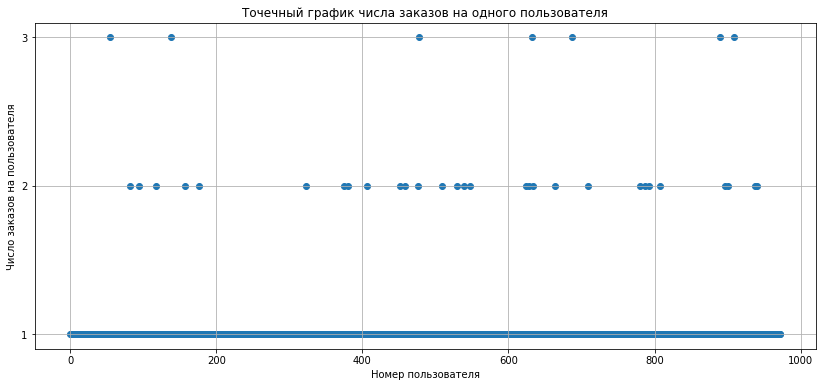

In [24]:
x_values = pd.Series(range(0,len(ordersByUsers)))

fig = plt.figure(figsize = (14,6)) 

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Точечный график числа заказов на одного пользователя')
ax.set_ylabel('Число заказов на пользователя')
ax.set_xlabel('Номер пользователя')
ax.grid(True)

yticks = np.arange(0, 12, 1)
ax.set_yticks(yticks)


plt.scatter(x_values, ordersByUsers['orders']);

Из графика видно, что основное количество заказов на пользователя составляет от 1 до 3. С количеством заказов выше - уже единичное число пользователей.

#### Задача 7. Перцентили количества заказов на пользователя.

In [25]:
opu_p95, opu_p99 = np.percentile(ordersByUsers['orders'], [95, 99])
print('Число заказов на пользователя на 95-ом перцентиле выборки: {0}, на 99-ом перцентиле: {1}.'.format(int(opu_p95), int(opu_p99)))

Число заказов на пользователя на 95-ом перцентиле выборки: 1, на 99-ом перцентиле: 2.


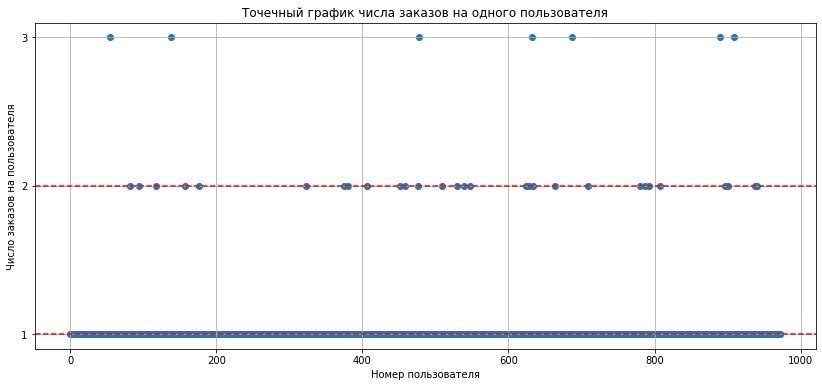

In [26]:
x_values = pd.Series(range(0,len(ordersByUsers)))

fig = plt.figure(figsize = (14,6)) 

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Точечный график числа заказов на одного пользователя')
ax.set_ylabel('Число заказов на пользователя')
ax.set_xlabel('Номер пользователя')
ax.grid(True)

yticks = np.arange(0, 12, 1)
ax.set_yticks(yticks)

plt.axhline(y=opu_p95, color='red', linestyle='--')
plt.axhline(y=opu_p99, color='red', linestyle='--')

plt.scatter(x_values, ordersByUsers['orders']);

Границу учета установим на уровне 95-го перцентиля в 2 заказа на пользователя. Пользователей с 3-мя заказами уже учитывать не будем.

#### Задача 8. Точечный график стоимостей заказов

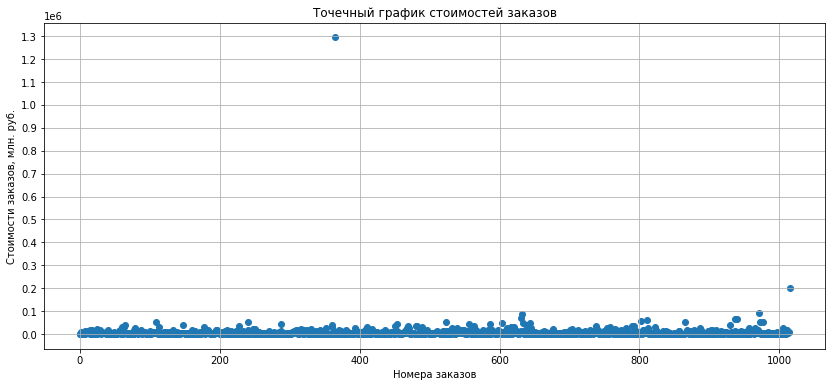

In [27]:
x_values = pd.Series(range(0,len(orders['revenue'])))

fig = plt.figure(figsize = (14,6)) 

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Точечный график стоимостей заказов')
ax.set_ylabel('Стоимости заказов, млн. руб.')
ax.set_xlabel('Номера заказов')
ax.grid(True)

yticks = np.arange(0, 1400000, 100000)
ax.set_yticks(yticks)

plt.scatter(x_values, orders['revenue']);

Для наглядности используем логарифмическую шкалу по вертикали.

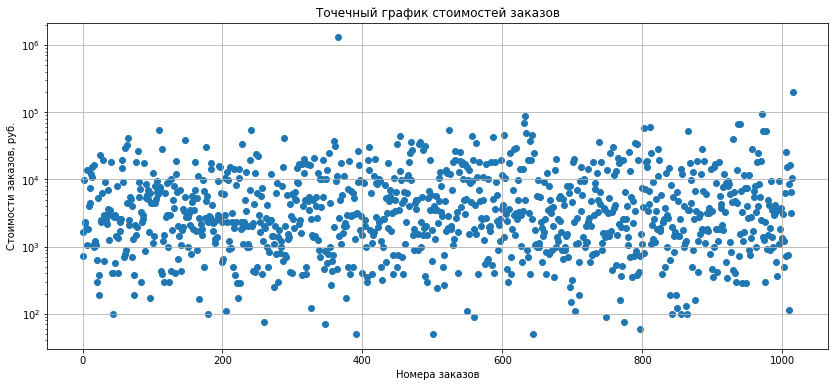

In [28]:
x_values = pd.Series(range(0,len(orders['revenue'])))

fig = plt.figure(figsize = (14,6)) 

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Точечный график стоимостей заказов')
ax.set_ylabel('Стоимости заказов, руб.')
ax.set_xlabel('Номера заказов')
ax.grid(True)

plt.yscale('log')

plt.scatter(x_values, orders['revenue']);

Точечный график стоимостей заказов с линейной шкалой и с исключением максимального выброса. 

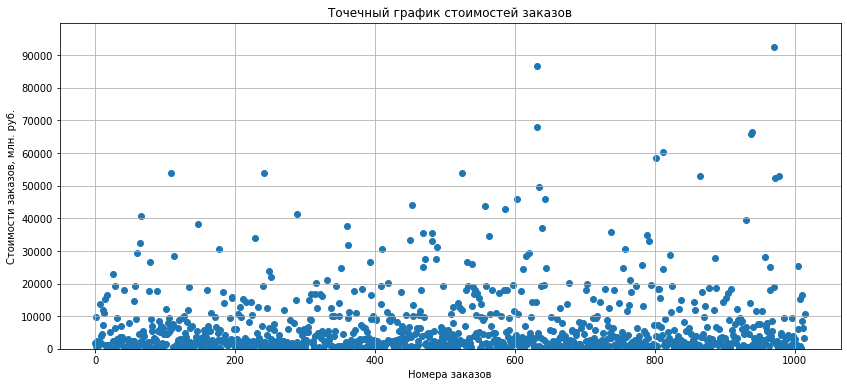

In [29]:
x_values = pd.Series(range(0,len(orders['revenue'])))

fig = plt.figure(figsize = (14,6)) 

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Точечный график стоимостей заказов')
ax.set_ylabel('Стоимости заказов, млн. руб.')
ax.set_xlabel('Номера заказов')
ax.grid(True)

yticks = np.arange(0, 100000, 10000)
ax.set_yticks(yticks)
plt.ylim([0, 100000])

plt.scatter(x_values, orders['revenue']);

В основном, стоимость всех заказов не превышает 100 000 руб. Заметны лишь два выброса, превышающих эти значения. 

#### Задача 9. Перцентили стоимости заказов.

In [30]:
oc_p95, oc_p99 = np.percentile(orders['revenue'], [95, 99])
print('Стоимость заказа на 95-ом перцентиле выборки: {0:0.2f}, на 99-ом перцентиле: {1:0.2f}.'.format(oc_p95, oc_p99))

Стоимость заказа на 95-ом перцентиле выборки: 26785.00, на 99-ом перцентиле: 53904.00.


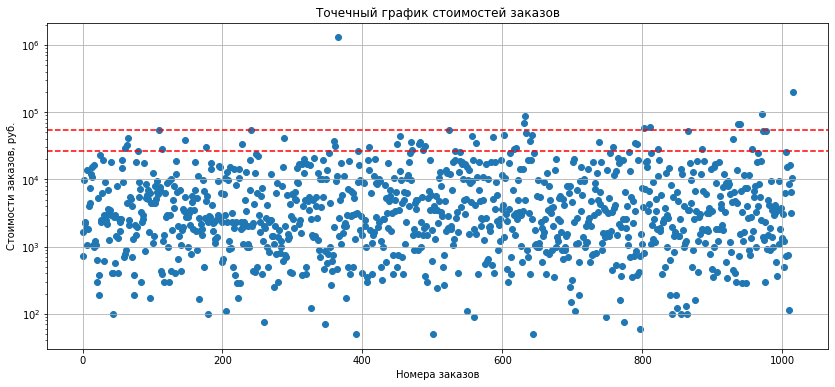

In [31]:
x_values = pd.Series(range(0,len(orders['revenue'])))

fig = plt.figure(figsize = (14,6)) 

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Точечный график стоимостей заказов')
ax.set_ylabel('Стоимости заказов, руб.')
ax.set_xlabel('Номера заказов')
ax.grid(True)

plt.yscale('log')

plt.axhline(y=oc_p95, color='red', linestyle='--')
plt.axhline(y=oc_p99, color='red', linestyle='--')

plt.scatter(x_values, orders['revenue']);

Границу учета установим на уровне 95-го перцентиля в 26785 рублей, заказы с большей стоимостью учитывать не будем.

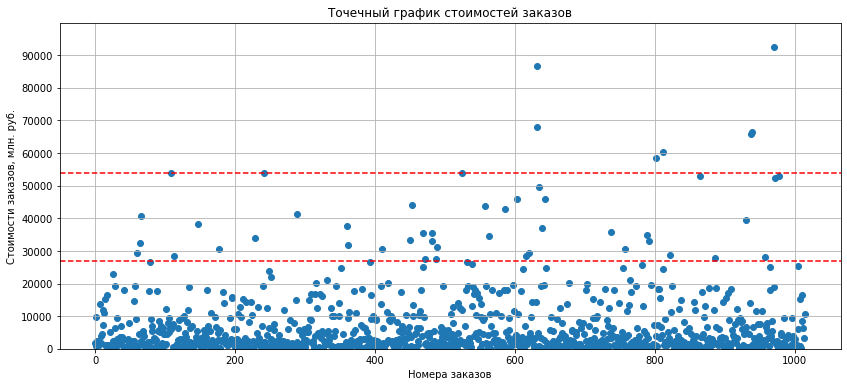

In [32]:
x_values = pd.Series(range(0,len(orders['revenue'])))

fig = plt.figure(figsize = (14,6)) 

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Точечный график стоимостей заказов')
ax.set_ylabel('Стоимости заказов, млн. руб.')
ax.set_xlabel('Номера заказов')
ax.grid(True)

yticks = np.arange(0, 100000, 10000)
ax.set_yticks(yticks)
plt.ylim([0, 100000])

plt.axhline(y=oc_p95, color='red', linestyle='--')
plt.axhline(y=oc_p99, color='red', linestyle='--')

plt.scatter(x_values, orders['revenue']);

#### Задача 10. Cтатистическая значимость различий в среднем  количестве заказов на посетителя по "сырым" данным

In [33]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'visitor_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

HTML(data.head().to_html())

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,22,162043,42,234381,39,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,53,288850,507,509,1845,1803
3,2019-08-04,11,41176,13,96890,77,388030,66,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,87,475648,756,707,3318,3280


In [34]:
cumulativeData

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.031989
1,2019-08-01,B,17,17,59758,713,0.023843
2,2019-08-02,A,42,36,234381,1338,0.031390
3,2019-08-02,B,40,39,221801,1294,0.030912
4,2019-08-03,A,66,60,346854,1845,0.035772
...,...,...,...,...,...,...,...
57,2019-08-29,B,510,490,4746610,17708,0.028801
58,2019-08-30,A,460,437,3311413,18037,0.025503
59,2019-08-30,B,531,511,4955833,18198,0.029179
60,2019-08-31,A,468,445,3364656,18736,0.024979


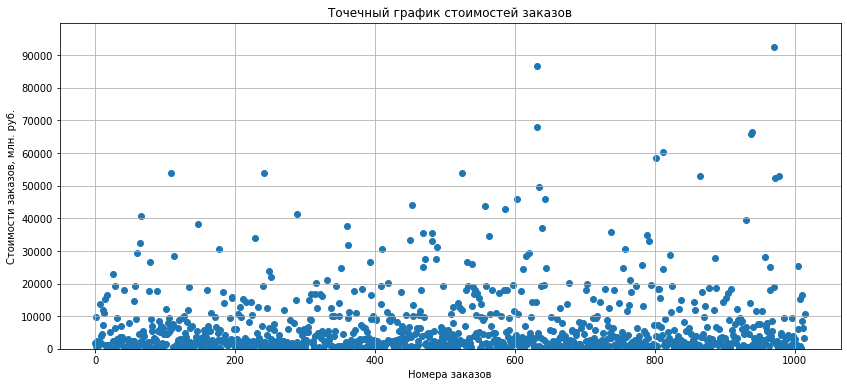

In [35]:
x_values = pd.Series(range(0,len(orders['revenue'])))

fig = plt.figure(figsize = (14,6)) 

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Точечный график стоимостей заказов')
ax.set_ylabel('Стоимости заказов, млн. руб.')
ax.set_xlabel('Номера заказов')
ax.grid(True)

yticks = np.arange(0, 100000, 10000)
ax.set_yticks(yticks)
plt.ylim([0, 100000])

plt.scatter(x_values, orders['revenue']);

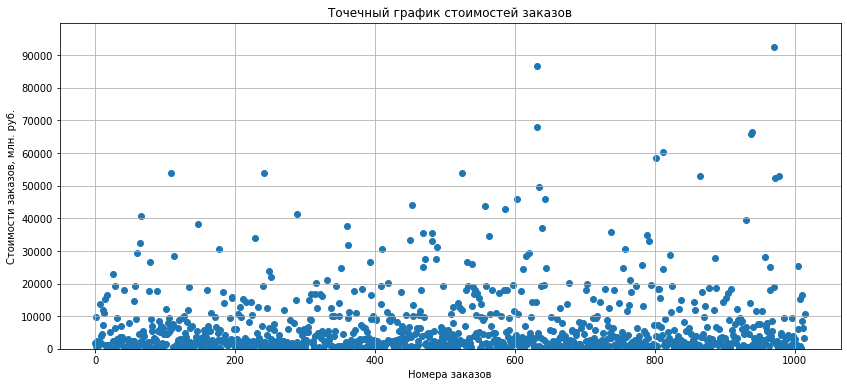

In [36]:
x_values = pd.Series(range(0,len(orders['revenue'])))

fig = plt.figure(figsize = (14,6)) 

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Точечный график стоимостей заказов')
ax.set_ylabel('Стоимости заказов, млн. руб.')
ax.set_xlabel('Номера заказов')
ax.grid(True)

yticks = np.arange(0, 100000, 10000)
ax.set_yticks(yticks)
plt.ylim([0, 100000])

plt.scatter(x_values, orders['revenue']);

Проверим гипотезу $H_0$ - среднее количество заказов на посетителя не изменилось.

Альтернативная гипотеза $H_1$ - среднее количество заказов на пользователя увеличилось.

Уровень значимости $\alpha$ = 0.05 (5%)

In [ ]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

Подготовим выборки к проверке критерием Манна-Уитни: объединим для каждой группы списки с количеством заказов для каждого из пользователей и списки нулей для пользователей, которые ничего не заказывали.

In [38]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [40]:
print("p-value: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, True, 'less')[1])) #Добавлен признак односторонней гипотезы

print("Относительный прирост среднего числа заказов на посетителя группы B к группе A: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.006
Относительный прирост среднего числа заказов на посетителя группы B к группе A: 0.160


p-value = 0.006 = 0,6% меньше порога 5%, соответственно, разница в данных групп A и B статистически значима и позволяет отвергнуть гипотезу $H_0$ в пользу $H_1$. Можем утверждать, что число заказов на посетителя увеличилось. При этом относительный прирост в группе B составил 16%.

#### Задача 11. Cтатистическая значимость различий в среднем  чеке заказов по "сырым" данным

Проверим гипотезу $H_0$ - среднй чек между группами не изменился.  
Альтернативная гипотеза $H_1$ - средний чек изменился.

Уровень значимости $\alpha$ = 0.05 (5%)

In [41]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                          orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост среднего чека группы B к группе A: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/
                       orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.829
Относительный прирост среднего чека группы B к группе A: 0.287


Сравниваем с $\alpha/2$ = 0.05/2 = 0.25 (2,5%), так как гипотеза двусторонняя.
   
p-value: 0.829 = 82.9% значительно больше 2,5% и не позволяет отвергнуть гипотезу о равенстве среднего чека между группами. То есть, хотя при наблюдении относительное увеличение среднего чека в группе B и составило почти 28,7%, оно не является статистически значимым.

#### Задача 12. Cтатистическая значимость различий в среднем  количестве заказов на посетителя по "очищенным" данным

Выделим пользователей, которых мы не будем учитывать из-за аномальных выбросов данных по ним.

In [42]:
# opu_p95  - 95-й перцентиль по заказам на пользователя из Задачи 7
# oc_p95 - 95-й перцентиль по стоимости заказа из Задачи 9

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > opu_p95]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > opu_p95]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > oc_p95]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print('Количество исключаемых пользователей:', abnormalUsers.shape[0])

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitor_id, dtype: int64
Количество исключаемых пользователей: 86


Проверим гипотезу $H_0$ - среднее количество заказов на посетителя не изменилось.

Альтернативная гипотеза $H_1$ - среднее количество заказов на пользователя увеличилось.

Уровень значимости $\alpha$ = 0.05 (5%)

In [44]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, True, 'less')[1]))
print('Относительный прирост среднего числа заказов на посетителя группы B к группе A: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value: 0.008
Относительный прирост среднего числа заказов на посетителя группы B к группе A: 0.174


p-value = 0.008 = 0,8% меньше порога 5%, соответственно, разница в данных групп A и B статистически значима и позволяет отвергнуть гипотезу $H_0$ в пользу $H_1$. Можем утверждать, что число заказов на посетителя увеличилось. При этом относительный прирост в группе B составил 17.4%.

#### Задача 13. Cтатистическая значимость различий в среднем  чеке заказов по "очищенным" данным

Проверим на очищенных данных гипотезу $H_0$ - средний чек между группами не изменился.

Альтернативная гипотеза $H_1$ - средний чек изменился.

Уровень значимости $\alpha$ = 0.05 (5%)

In [45]:
print(
    'p-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительный прирост среднего чека группы B к группе A: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.727
Относительный прирост среднего чека группы B к группе A: -0.034


Сравниваем с $\alpha/2$ = 0.05/2 = 0.25 (2,5%), так как гипотеза двусторонняя.
   
p-value: 0.727 = 72,7% значительно больше 2,5% и не позволяет отвергнуть гипотезу о равенстве среднего чека между группами. То есть, хотя при наблюдении относительное уменьшение среднего чека в группе B на "чистых" данных и составило 3,4%, оно не является статистически значимым.

#### Задача 14. Решение по результатам теста

Данные для принятия решения об увеличении в группе B среднего количества заказов на пользователя являются статистически значимыми. В отношении этого показателя тест можно прекращать.

Для того, чтобы понять, подходят ли нам данные по среднему чеку, воспользуемся данными по числу посещений, конверсии группы A и калькулятором расчета количества измерений. 

Приблизительно оценим, на какую минимальную точность мы можем рассчитывать при нашем количестве посетителей за время теста.
Мы знаем количество конверсий (смотрим кумулятивные данные по группе A на последнюю дату). Это 3% (с округлением до целых для калькулятора  https://www.evanmiller.org/ab-testing/sample-size.html)
Дальше подбираем проценты минимально выявляемого эффекта, чтобы размер выборки (число визитов) было не более нашего числа визитов из кумулятивных данных на конец теста.

In [46]:
cumulativeData[cumulativeData['date']==cumulativeData['date'].max()]

,date,group,orders,buyers,revenue,visitors,conversion
60,2019-08-31,A,468,445,3364656,18736,0.024979
61,2019-08-31,B,548,528,5068972,18916,0.028970


То есть, мы видим, что конверсия около 3%. Смотрим
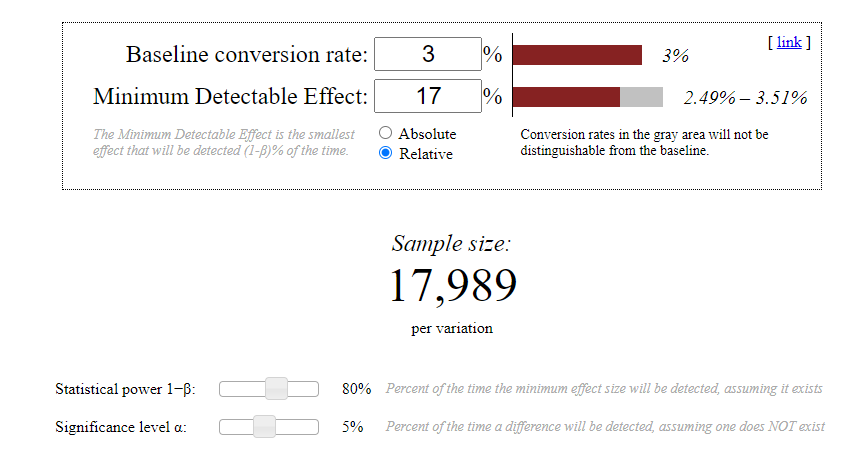

Под наше количество посетителей в группе подбираем тот уровень относительного изменения, которое мы можем выявить со статистической значимостью. Получаем 17% относительных изменений. Из этого, кстати, заметно, что выявленное изменение заказов на посетителя очень близко в минимально определяемому при таком количестве наблюдений.

А поскольку за наше количество измерений (около 19000) изменения среднего чека не были статистически значимыми, то реальная величина относительных изменений в эксперименте меньше 17% и нам не хватило выборки для ее выявления.

Если для нас такая относительная точность в 17% для определения изменения среднего чека допустима, то эксперимент можно прекращать.

## Выводы

1. Исходные данные были готовы к работе с выполнением небольших операций по преобразованию типов даты и переименованию колонок.
2. При приоритизации гипотез по фреймворку ICE наибольший приоритет получила гипотеза 8 "Запустить акцию, дающую скидку на товар в день рождения".
3. При приоритизации гипотез по фреймворку RICE наибольший приоритет получила гипотеза 7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".
4. При смене фреймворка приоритизации, в целом, состав ТОП5 приоритетов не изменился. Но значительно изменился их порядок ранжирования. Это произошло потому, что в случае RICE мы дополнительно учли охват воздействия гипотез.
5. В задаче 1 кумулятивная выручка постоянно растет по обеим группам. В целом, рост происходит схожими темпами, однако у группы B заметен сильный всплеск выручки 19.08.2019. Это могло произойти либо из-за необычного большого количества заказов в этот день, либо заказа с высоким чеком (именно последнее подтверждается в следующем пункте).
6. В задаче 2 видно, что в группе B  значительно увеличился средний чек 19 августа. И это была нетипичная ситуация, так как далее кумулятивные данные начали снижаться за счет более низких средних чеков в последующие дни.<br>Кроме того, в той же группе B  и до этого случались увеличения чека 2 августа, а также с 6 по 8, 15 августа.<br> В группе A средний чек сначала снижался (причем значительно, поскольку мы из предыдущего графика знаем, что общая выручка росла). Но с 7 августа размер чека постоянно рос до 13 августа. Далее размер среднего чека постепенно стабилизировался.
7. В задаче 3 на графике относительного между группами изменения кумулятивного среднего чека видно, что изначально седний чек у группы A был выше.Затем большую часть времени кумулятивный средний чек группы B был выше, чем у группы A.<br>Исключение составляет период с 12 по 15 августа.<br>Последние 3 дня соотношение было приблизительно постоянным.
8. В задаче 4 на графике кумулятивного среднего количества заказов на посетителя видим вначале значительные колебания конверсии, что говорит о том, что периоды одинаковой конверсии не постоянны, а уровень конверсии постоянно меняется, однако со временем при кумулятивном рассмотрении эти неравномерности сглаживаются.<br>Соответственно, постепенно становится хорошо заметно установление у групп A и B стабильно разных значений конверсии.
9. В задаче 5 на графике относительного изменения кумулятивного среднего количества заказов на посетителя видно, что начиная с 6 августа количество заказов в группе B начинает значительно расти и постепенно, по мере накопления суммарных значений, закрепляется превосходящее количество заказов на посетителя в группе B по отношению к группе A.<br>В начале заметно преобладание количество заказов у группы A, но это были локальные всплески, которые впоследствии нивелировались общими суммарными занчениями.
10. В задаче 6 на точечном графике количества заказов по пользователям видно, что основное количество заказов на пользователя составляет от 1 до 3. С количеством заказов выше - уже единичное число пользователей.
11. В задаче 7 границу учета в тесте установим на уровне 95-го перцентиля в 2 заказа на пользователя. Пользователей с 3-мя заказами уже учитывать не будем.
12. В задаче 8 на точечном графике стоимостей заказов видно, что, в основном, стоимость всех заказов не превышает 100 000 руб. Заметны лишь два выброса, превышающих эти значения.
13. В задаче 9 границу учета в тесте стоимости заказа установим на уровне 95-го перцентиля в 28000 рублей, заказы с большей стоимостью учитывать не будем.
14. В задаче 10 по определению статистической значимости различий в среднем  количестве заказов на посетителя по "сырым" данным получаем p-value = 0.017 = 1,7% меньше порога 5%, соответственно, разница в данных групп A и B статистически значима и позволяет отвергнуть гипотезу  $𝐻_0$. Можем утверждать, что число заказов в группе B на посетителя изменилось. При этом относительный прирост в группе B составил 13.8%.
15. В задаче 11 по определению статистической значимости различий в среднем чеке заказов по "сырым" данным получаем p-value: 0.729 = 72.9% значительно больше 5%, что не позволяет отвергнуть гипотезу о равенстве среднего чека между группами. То есть, хотя при наблюдении относительное увеличение среднего чека в группе B и составило почти 26%, оно не является статистически значимым.
16. В задаче 12 по определению статистической значимости различий в среднем количестве заказов на посетителя по "очищенным" данным получаем p-value: 0.013 на очищенных данных, что показало  статистическую значимость результатов большую по сравнению с "сырыми" данными (0.017), что позволяет с еще большей уверенностью отвергнуть гипотезу $H_0$.<br>Прирост среднего числа заказов на посетителя в 17,3% также выше, чем был на "сырых" данных (13,8%).
17. В задаче 13 по определению статистической значимости различий в среднем чеке заказов по "очищенным" данным получаем p-value = 0.738, что отчетливее демонстрирует низкий уровень статистической значимости в различиях результатов у двух групп. Гипотеза равенства среднего чека не отвергается.<br>При этом по "очищенным" данным средний чек снизился на 2%, хотя на "сырых" данных был рост почти в 26%.
18. В задаче 14 решение по результатам теста: остановить тест, зафиксировать улучшение количества заказов на пользователя в группе B и отсутствие различий в среднем чеке между группами.   